# Multi-Class Classification using ULMFit

Classifying the sentences from IRs (Instruction Reports) into different labels of "Human Errors" i.e.: <Br>
T: Team Cognition <br>
P: Procedural <br>
O: Organizational <br>
D: Design <br>
H: Human <br>
<br>
For Training Data, we have sentences labelled by the coders - Sally, Frenard and Trixy<BR>
<br>
The coders have also labelled sentences as 'U': useless

## 1. Configuring GPU

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
import glob

pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Import the Data


In [0]:
df = []

files = [f for f in glob.glob("*.csv")]
df_raw = pd.DataFrame()

for file in files:
 
  df = pd.read_csv(file)
  df['text'] = df['text'].apply(str)
  df_raw = pd.concat([df_raw , df], ignore_index=True)

df = df_raw.dropna()
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,end_pos,file,label_Frenard,label_SALLY,line,start_pos,text
0,16,ML14041A484.txt,U,U,0,0,UNITE D S TATE S
1,35,ML14041A484.txt,U,U,2,0,NUC LEAR REGULATOR Y C OMMI S SI ON
2,67,ML14041A484.txt,U,U,3,0,"R E G IO N I V 1600 EAST LAMAR BLVD AR L INGTON , TEXAS 76011- 4511"
3,17,ML14041A484.txt,U,U,5,0,10-Feb-14
4,126,ML14041A484.txt,U,U,7,0,"Mr. Adam C. Heflin President, Chief Executive Officer, and Chief Nuclear Officer Wolf Creek Nuclear Operating Corporation P.O."


## 3. Data Preprocessing


In [0]:
# Get labels of these coders
TRAINING_LABEL = ['label_SALLY', 'label_Frenard']

# Get labels of sentences, which were labelled same by the coders (excluding 'U')
def get_similar(row):
    if len(TRAINING_LABEL)==2:
        if row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] and row[TRAINING_LABEL[0]] != 'U':
            return row[TRAINING_LABEL[0]]
        else:
            return np.NaN
    if len(TRAINING_LABEL)==3:
        if row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] == row[TRAINING_LABEL[2]] and row[TRAINING_LABEL[0]] != 'U':
            return row[TRAINING_LABEL[0]]
        else:
            return np.NaN

# Get labels of sentences, which were labelled different by the coders (excluding 'U')
def get_different(row):
    if len(TRAINING_LABEL) == 2:
        if row[TRAINING_LABEL[0]] == 'U' or row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]]:
            return np.NaN
        else:
            return row[TRAINING_LABEL[0]]
    if len(TRAINING_LABEL) == 3:
        if row[TRAINING_LABEL[0]] == 'U' or row[TRAINING_LABEL[0]] == row[TRAINING_LABEL[1]] == row[TRAINING_LABEL[2]]:
            return np.NaN
        else:
            return row[TRAINING_LABEL[0]]

# Get label of a sentence (first label if there are multiple labels)
# Get NULL if the label is 'U'
def class_label_handler(class_label):
  if 'U' in class_label:
    return np.NaN
  else:
    return class_label.split(',')[0]

for label in TRAINING_LABEL:  
  df[label] = df[label].apply(class_label_handler)

if len(TRAINING_LABEL) > 1:
  df['Y'] = df.apply(get_similar, axis=1)
else:
  df['Y'] = df[TRAINING_LABEL]

# Drop rows with NULL labels
for label in TRAINING_LABEL:
  df = df.drop(label, axis=1)
  
df = df.dropna()

'''
label_idx = {'T':0, 'P': 1, 'O': 2, 'D': 3, 'H': 4}
def changing_labels_to_integers(class_label):
  return label_idx[class_label]

df['Y']=df['Y'].apply(changing_labels_to_integers)
'''
print(len(df['Y']))
df.head()

70


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,end_pos,file,line,start_pos,text,Y
57,2013,ML14041A484.txt,35,1803,"This finding has a crosscutting aspect in the area of human performance associated with resources, because the licensee failed to ensure that personnel were adequately trained to assure nuclear safety [H.2(b)].",O
60,2420,ML14041A484.txt,35,2234,"Specifically, the licensee failed to determine the cause of the train A Class 1E air conditioner slug flow in the refrigerant prior to experiencing multiple failures and plant shutdowns.",O
64,3010,ML14041A484.txt,35,2857,"Failure to preclude repetitive failures of the train A Class 1E air conditioner, a significant condition adverse to quality, is a performance deficiency.",O
71,977,ML14041A484.txt,39,827,"The licensee did not ensure complete, accurate and up-to-date design documentation, procedures, and work packages, and correct labeling of components.",O
146,974,ML14041A484.txt,81,918,There were two crew failures and 11 individual failures.,T


In [0]:
new_df = pd.DataFrame()
new_df['label'] = df['Y']
new_df['text'] = df['text']

new_df.head()

,label,text
57,O,"This finding has a crosscutting aspect in the area of human performance associated with resources, because the licensee failed to ensure that personnel were adequately trained to assure nuclear safety [H.2(b)]."
60,O,"Specifically, the licensee failed to determine the cause of the train A Class 1E air conditioner slug flow in the refrigerant prior to experiencing multiple failures and plant shutdowns."
64,O,"Failure to preclude repetitive failures of the train A Class 1E air conditioner, a significant condition adverse to quality, is a performance deficiency."
71,O,"The licensee did not ensure complete, accurate and up-to-date design documentation, procedures, and work packages, and correct labeling of components."
146,T,There were two crew failures and 11 individual failures.


## 4. Create train & validation datasets and FastAI data bunch

In [0]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(new_df, stratify = new_df['label'], test_size = 0.2)

df_trn.shape, df_val.shape

((56, 2), (14, 2))

In [0]:

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk the xxmaj inspection xxmaj xxunk xxmaj xxunk xxunk , xxmaj appendix b , "" xxmaj xxunk xxmaj xxunk , "" the xxunk determined that the finding was more than xxunk because the performance deficiency was associated with the xxmaj xxunk xxmaj systems xxmaj cornerstone xxunk of human performance , and xxunk the cornerstone xxunk of xxunk the xxunk , reliability , and xxunk of systems that xxunk",O
"xxbos xxmaj contrary to the above , on xxmaj october , xxunk , 2011 , the xxup nrc identified that the licensee failed to ensure that , during post - fire safe shutdown , xxmaj unit 1 and xxmaj unit 2 reactor coolant process variables would be maintained within those predicted for a loss of normal ac power .",O
"xxbos xxmaj the inspectors identified a xxmaj xxunk xxunk violation of xxunk xxup xxunk xxunk xxmaj appendix b , xxmaj xxunk xxup xxunk , "" xxmaj design xxmaj control , "" for failure to assure that the design basis , as specified in the license application , was xxunk xxunk into drawings and the xxunk plant configuration .",D
"xxbos xxmaj specifically , the licensee failed to ensure that , during xxunk safe shutdown involving a large fire in the xxunk control room ( xxup mcr ) , xxmaj unit 1 and xxmaj unit 2 xxup rcs process variables would be maintained within those predicted for a loss of normal ac power .",O
"xxbos xxmaj based on xxunk of the actions implemented related to the xxmaj reactor xxmaj xxunk xxmaj xxunk xxmaj program aging management program , the team could not xxunk that the licensee implemented actions that would effectively xxunk the effects of aging during the period of extended operation .",O


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')
data_lm = load_data('./', 'data_lm_export.pkl')
data_clas = load_data('./', 'data_clas_export.pkl', bs=32)

## 5. Create and Train the Language Model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 2.75E-01


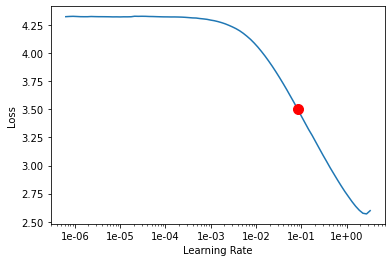

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, metrics=(accuracy))
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.314059,3.683757,0.308929,00:00
1,4.247437,3.159083,0.358036,00:00


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.983620,3.151979,0.356473,00:00
1,2.965614,2.891339,0.397991,00:00


In [0]:
learn.predict("the inspection", n_words=10)

'the inspection that failed to specifically determine a design failed .'

In [0]:
learn.save_encoder('ft_enc')

## 6. Using the Language Model to Train the Classifier


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=(accuracy))
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (56 items)
x: TextList
xxbos xxmaj the inspectors identified a finding of very low safety significance for failure to assure that the design basis for the dry cooling tower diesel - driven sump pumps was properly implemented .,xxbos xxmaj xxunk , the team determined that the licensee did not follow the requirements in xxmaj procedure xxup xxunk - xxup xxunk to xxunk these cracks during a subsequent inspection in xxunk to xxunk xxunk xxunk or determine the cracks had not xxunk .,xxbos xxmaj specifically , xxmaj exelon failed to xxunk the requirements of xxunk xxmaj preventive xxmaj maintenance xxmaj program as xxunk in procedure xxup xxunk .,xxbos xxmaj the operability section did not address the xxunk and xxunk of xxup xxunk piping .,xxbos xxmaj xxunk inspection report xxunk xxunk an xxup xxunk for a failure to perform an operability determination in xxunk with a procedure xxunk a xxunk on the xxunk xxunk of the xxunk xxunk was ident

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.32E-01


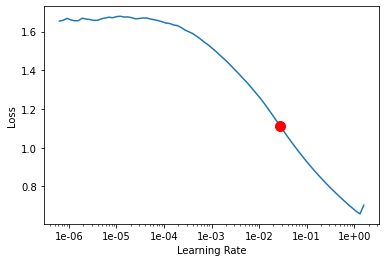

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.623055,1.536609,0.642857,00:00
1,1.519281,1.970481,0.071429,00:00


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(40, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.905528,1.894174,0.071429,00:00
1,0.902283,1.868204,0.071429,00:00
2,0.928634,1.863538,0.071429,00:00
3,0.918860,1.845146,0.071429,00:00
4,0.914006,1.832436,0.071429,00:00
5,0.902161,1.808401,0.071429,00:00
6,0.887307,1.779308,0.071429,00:00
7,0.863222,1.749506,0.071429,00:00
8,0.837874,1.723872,0.142857,00:00
9,0.820065,1.695543,0.142857,00:00


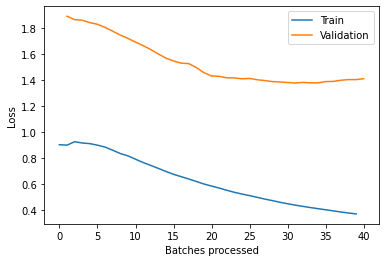

In [0]:

learn.recorder.plot_losses()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.200485,1.421350,0.571429,00:00
1,0.195048,1.421298,0.571429,00:00
2,0.185775,1.429333,0.571429,00:00
3,0.182570,1.435213,0.571429,00:00
4,0.183280,1.455516,0.571429,00:00
5,0.183629,1.476678,0.571429,00:00
6,0.180735,1.486119,0.500000,00:00
7,0.185470,1.498608,0.500000,00:00
8,0.183109,1.520437,0.500000,00:00
9,0.179461,1.540961,0.500000,00:00


## 7. Analyzing our results

In [0]:
acc = max(learn.recorder.metrics)
val_acc = format(acc[0])
print('The accuracy is {0} %.'.format(val_acc))

The accuracy is 0.5714285969734192 %.


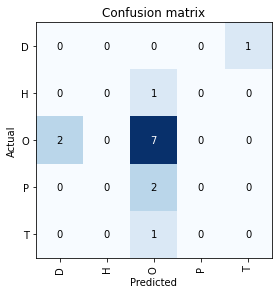

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
interp.most_confused()

[('O', 'D', 2), ('P', 'O', 2), ('D', 'T', 1), ('H', 'O', 1), ('T', 'O', 1)]

In [0]:
acc = accuracy(preds, y)
acc

tensor(0.5000)

In [0]:
preds = []
x = list(df_val.text)
y = list(df_val.label)
ok_pred = 0
for i in range(0,len(x)):
    p = learn.predict(x[i])
    preds.append(str(p[0]))
    if str(p[0])==y[i]:
      ok_pred += 1

print(ok_pred)
test_acc = ok_pred/len(x)
print(test_acc)

7
0.5


## 8. Saving the results


In [0]:
df_test = pd.DataFrame()
df_test['text'] = df_val['text']
df_test['Y'] = df_val['label']
df_test['Predicted_Values'] = preds
df_test.head()

,text,Y,Predicted_Values
1527,"The licensee investigated these concerns and determined that this alternate sample point was not adequate in that it did not meet the intent of Technical Specification 3.3.3.1, Action 28, which required that grab samples be taken every 8 hours.",O,O
2276,"Specifically, by failing to establish a preventive maintenance strategy for fire safe shutdown transfer/isolation switches, Exelon did not ensure that the local control circuits for several 4KV breakers would be isolated from the effects of fire damage.",O,O
1715,"Current plant configuration and Drawing G-499 S06, ""Common Foundation Structure, Masonry,"" Sheet 6, do not conform to the design basis, in that there are no openings other than the floor drains.",D,T
3882,"Also, the source of the water was not addressed.",P,O
3881,The operability section did not address the operability of the AFW pumps due to internal flooding from the clogged drain.,P,O


In [0]:
df_test.to_csv('gdrive/My Drive/Colab Notebooks/DS_Lab/Results_ULMFit/Sally_Frenard_Agree.csv', index = False)
df_test.head()

,text,Y,Predicted_Values
1527,"The licensee investigated these concerns and determined that this alternate sample point was not adequate in that it did not meet the intent of Technical Specification 3.3.3.1, Action 28, which required that grab samples be taken every 8 hours.",O,O
2276,"Specifically, by failing to establish a preventive maintenance strategy for fire safe shutdown transfer/isolation switches, Exelon did not ensure that the local control circuits for several 4KV breakers would be isolated from the effects of fire damage.",O,O
1715,"Current plant configuration and Drawing G-499 S06, ""Common Foundation Structure, Masonry,"" Sheet 6, do not conform to the design basis, in that there are no openings other than the floor drains.",D,T
3882,"Also, the source of the water was not addressed.",P,O
3881,The operability section did not address the operability of the AFW pumps due to internal flooding from the clogged drain.,P,O


In [0]:
from sklearn.metrics import confusion_matrix

pred_labels = list(set(df_test['Y']))

conf_mat = confusion_matrix(df_test['Y'], df_test['Predicted_Values'], pred_labels)
conf_mat

array([[0, 0, 1, 0, 0],
       [2, 7, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 2, 0, 0, 0]])

In [0]:
final_result = pd.DataFrame(columns = ['Coder','Train_Accuracy','Val_Accuracy','Test_Accuracy','#TestData','#AllData'])
list = []
list.append('Sally_Frenard_Agree')
final_result['Coder'] = list
list = []
list.append(val_acc)
final_result['Val_Accuracy'] = list
list = []
list.append(test_acc)
final_result['Test_Accuracy'] = list
list = []
list.append(len(df_val['text']))
final_result['#TestData'] = list
list = []
list.append(len(df_trn['text']) + len(df_val['text']))
final_result['#AllData'] = list
list = []
list.append(pred_labels)
final_result['Classes'] = list
list = []
list.append(conf_mat)
final_result['Confusion Matrix'] = list
final_result

,Coder,Train_Accuracy,Val_Accuracy,Test_Accuracy,#TestData,#AllData,Classes,Confusion Matrix
0,Sally_Frenard_Agree,NaN,0.5714285969734192,0.5,70,14,"[D, O, T, H, P]","[[0, 0, 1, 0, 0], [2, 7, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 2, 0, 0, 0]]"


In [0]:
import tensorflow as tf
if not tf.io.gfile.exists("gdrive/My Drive/Colab Notebooks/DS_Lab/Results_ULMFit/Final_Results.csv"):
  final_result.to_csv("gdrive/My Drive/Colab Notebooks/DS_Lab/Results_ULMFit/Final_Results.csv", header=True)
else:
  final_result.to_csv("gdrive/My Drive/Colab Notebooks/DS_Lab/Results_ULMFit/Final_Results.csv", mode='a', header=False)